In [1]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data
import os

def load_and_process_data(prefix, folder):
    node_file = f'{folder}/{prefix}_nodes.csv'
    link_file = f'{folder}/{prefix}_links.csv'

    node_data = pd.read_csv(node_file)
    link_data = pd.read_csv(link_file)

    # Assuming the ground truth labels are in the same format
    labels = node_data['ground_truth'].values
    features = node_data.drop(columns=['ground_truth'])

    node_features = features[['atom_type', 'residue_type', 'radius', 'voromqa_sas_potential', 'residue_mean_sas_potential', 'residue_sum_sas_potential', 'residue_size', 'sas_area', 'voromqa_sas_energy', 'voromqa_depth', 'voromqa_score_a', 'voromqa_score_r', 'volume', 'volume_vdw', 'ufsr_a1', 'ufsr_a2', 'ufsr_c2', 'ufsr_c3', 'ev28', 'ev56']]
    link_features = link_data[['atom_index1', 'atom_index2','area', 'boundary', 'distance', 'voromqa_energy', 'seq_sep_class', 'covalent_bond', 'hbond']]

    edge_index = torch.tensor(np.array([link_features['atom_index1'].values, link_features['atom_index2'].values]), dtype=torch.long)

    self_links = torch.arange(0, len(node_features))
    edge_index = torch.cat([edge_index, torch.stack([self_links, self_links])], dim=1)
    edge_index = torch.cat([edge_index, edge_index[[1, 0], :]], dim=1)  # Add reverse direction

    node_features_tensor = torch.tensor(node_features.values, dtype=torch.float)
    labels_tensor = torch.tensor(labels, dtype=torch.float)

    data = Data(x=node_features_tensor, edge_index=edge_index, y=labels_tensor)

    return data

candidate_pairs_file = 'holo/candidate_pairs.txt'
candidate_pairs = pd.read_csv(candidate_pairs_file, delim_whitespace=True)

graphs = {}
for index, row in candidate_pairs.iterrows():
    holo_prefix = f"{row['holo_pdb_id']}_{row['holo_chain_id']}"
    graphs[holo_prefix] = load_and_process_data(holo_prefix, 'holo')

save_dir = 'sh'
os.makedirs(save_dir, exist_ok=True)

for prefix, graph in graphs.items():
    save_path = os.path.join(save_dir, f'{prefix}_graph.pt')
    torch.save(graph, save_path)

print(f"All HOLO graphs have been saved in the directory: {save_dir}")

All HOLO graphs have been saved in the directory: sh


In [11]:
import os
import pandas as pd
import torch
from torch_geometric.data import DataLoader, Batch
import matplotlib.pyplot as plt

# Function to load data pairs
def load_data_pairs(apo_folder='sg', holo_folder='sh', pairs_file='apo/candidate_pairs.txt'):
    pairs = pd.read_csv(pairs_file, delim_whitespace=True)
    data_pairs = []
    for index, row in pairs.iterrows():
        apo_prefix = f"{row['apo_pdb_id']}_{row['apo_chain_id']}"
        holo_prefix = f"{row['holo_pdb_id']}_{row['holo_chain_id']}"
        apo_graph_path = os.path.join(apo_folder, f'{apo_prefix}_graph.pt')
        holo_graph_path = os.path.join(holo_folder, f'{holo_prefix}_graph.pt')
        if os.path.exists(apo_graph_path) and os.path.exists(holo_graph_path):
            apo_graph = torch.load(apo_graph_path)
            holo_graph = torch.load(holo_graph_path)
            data_pairs.append((apo_graph, holo_graph))
    return data_pairs

# Function to collate graphs for DataLoader
def collate_graphs(data_list):
    apo_data_list, holo_data_list = zip(*data_list)
    apo_batch = Batch.from_data_list(apo_data_list)
    holo_batch = Batch.from_data_list(holo_data_list)
    return apo_batch, holo_batch

# Load data pairs and set up DataLoader
data_pairs = load_data_pairs()
train_loader = DataLoader(data_pairs, batch_size=32, shuffle=True, collate_fn=collate_graphs)

# Inspect the first batch from DataLoader
first_batch = next(iter(train_loader))
apo_batch, holo_batch = first_batch

# Print the shapes of the tensors in the first batch
print("APO Batch:")
print("x shape:", apo_batch.x.shape)
print("edge_index shape:", apo_batch.edge_index.shape)
print("batch shape:", apo_batch.batch.shape)
print("y shape:", apo_batch.y.shape)

print("\nHOLO Batch:")
print("x shape:", holo_batch.x.shape)
print("edge_index shape:", holo_batch.edge_index.shape)
print("batch shape:", holo_batch.batch.shape)
print("y shape:", holo_batch.y.shape)

/home/flahaari/.local/lib/python3.8/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


APO Batch:
x shape: torch.Size([75498, 20])
edge_index shape: torch.Size([2, 1227630])
batch shape: torch.Size([75498])
y shape: torch.Size([75498])

HOLO Batch:
x shape: torch.Size([75486, 20])
edge_index shape: torch.Size([2, 1230080])
batch shape: torch.Size([75486])
y shape: torch.Size([75486])


/home/flahaari/.local/lib/python3.8/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Epochs:   0%|                                           | 0/200 [00:00<?, ?it/s]/home/flahaari/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epochs:   0%|▏                                  | 1/200 [00:06<20:24,  6.15s/it]

Epoch 1/200, Loss: 754.3553


Epochs:   1%|▎                                  | 2/200 [00:12<19:58,  6.05s/it]

Epoch 2/200, Loss: 831.2708


Epochs:   2%|▌                                  | 3/200 [00:19<22:13,  6.77s/it]

Epoch 3/200, Loss: 72.4433


Epochs:   2%|▋                                  | 4/200 [00:26<21:41,  6.64s/it]

Epoch 4/200, Loss: 126.0959


Epochs:   2%|▉                                  | 5/200 [00:33<21:50,  6.72s/it]

Epoch 5/200, Loss: 30.5459


Epochs:   3%|█                                  | 6/200 [00:38<20:34,  6.37s/it]

Epoch 6/200, Loss: 54.7591


Epochs:   4%|█▏                                 | 7/200 [00:44<19:40,  6.12s/it]

Epoch 7/200, Loss: 6.2870


Epochs:   4%|█▍                                 | 8/200 [00:49<19:02,  5.95s/it]

Epoch 8/200, Loss: 12.5074


Epochs:   4%|█▌                                 | 9/200 [00:55<18:40,  5.87s/it]

Epoch 9/200, Loss: 4.3371


Epochs:   5%|█▋                                | 10/200 [01:01<18:56,  5.98s/it]

Epoch 10/200, Loss: 6.2123


Epochs:   6%|█▊                                | 11/200 [01:08<19:05,  6.06s/it]

Epoch 11/200, Loss: 1.5718


Epochs:   6%|██                                | 12/200 [01:14<19:19,  6.17s/it]

Epoch 12/200, Loss: 6.0928


Epochs:   6%|██▏                               | 13/200 [01:20<19:01,  6.10s/it]

Epoch 13/200, Loss: 2.3197


Epochs:   7%|██▍                               | 14/200 [01:26<18:24,  5.94s/it]

Epoch 14/200, Loss: 3.8092


Epochs:   8%|██▌                               | 15/200 [01:31<18:04,  5.86s/it]

Epoch 15/200, Loss: 1.8032


Epochs:   8%|██▋                               | 16/200 [01:37<17:40,  5.76s/it]

Epoch 16/200, Loss: 1.4207


Epochs:   8%|██▉                               | 17/200 [01:42<17:22,  5.70s/it]

Epoch 17/200, Loss: 0.9271


Epochs:   9%|███                               | 18/200 [01:48<17:06,  5.64s/it]

Epoch 18/200, Loss: 2.2688


Epochs:  10%|███▏                              | 19/200 [01:53<16:54,  5.61s/it]

Epoch 19/200, Loss: 2.4219


Epochs:  10%|███▍                              | 20/200 [01:59<16:51,  5.62s/it]

Epoch 20/200, Loss: 4.7585


Epochs:  10%|███▌                              | 21/200 [02:05<16:55,  5.67s/it]

Epoch 21/200, Loss: 3.4850


Epochs:  11%|███▋                              | 22/200 [02:10<16:41,  5.63s/it]

Epoch 22/200, Loss: 1.3455


Epochs:  12%|███▉                              | 23/200 [02:16<16:29,  5.59s/it]

Epoch 23/200, Loss: 1.2422


Epochs:  12%|████                              | 24/200 [02:21<16:19,  5.57s/it]

Epoch 24/200, Loss: 0.9338


Epochs:  12%|████▎                             | 25/200 [02:27<16:09,  5.54s/it]

Epoch 25/200, Loss: 0.7698


Epochs:  13%|████▍                             | 26/200 [02:32<16:02,  5.53s/it]

Epoch 26/200, Loss: 0.7624


Epochs:  14%|████▌                             | 27/200 [02:38<15:51,  5.50s/it]

Epoch 27/200, Loss: 1.0332


Epochs:  14%|████▊                             | 28/200 [02:43<15:46,  5.50s/it]

Epoch 28/200, Loss: 2.9563


Epochs:  14%|████▉                             | 29/200 [02:49<15:39,  5.50s/it]

Epoch 29/200, Loss: 3.7959


Epochs:  15%|█████                             | 30/200 [02:54<15:34,  5.50s/it]

Epoch 30/200, Loss: 2.6696


Epochs:  16%|█████▎                            | 31/200 [03:00<15:29,  5.50s/it]

Epoch 31/200, Loss: 1.8334


Epochs:  16%|█████▍                            | 32/200 [03:06<15:40,  5.60s/it]

Epoch 32/200, Loss: 0.6645


Epochs:  16%|█████▌                            | 33/200 [03:11<15:47,  5.67s/it]

Epoch 33/200, Loss: 0.9084


Epochs:  17%|█████▊                            | 34/200 [03:17<15:33,  5.62s/it]

Epoch 34/200, Loss: 0.4662


Epochs:  18%|█████▉                            | 35/200 [03:22<15:22,  5.59s/it]

Epoch 35/200, Loss: 0.5761


Epochs:  18%|██████                            | 36/200 [03:28<15:12,  5.56s/it]

Epoch 36/200, Loss: 2.6791


Epochs:  18%|██████▎                           | 37/200 [03:33<15:03,  5.54s/it]

Epoch 37/200, Loss: 85.2821


Epochs:  19%|██████▍                           | 38/200 [03:39<14:55,  5.53s/it]

Epoch 38/200, Loss: 12.2623


Epochs:  20%|██████▋                           | 39/200 [03:44<14:48,  5.52s/it]

Epoch 39/200, Loss: 17.3816


Epochs:  20%|██████▊                           | 40/200 [03:50<14:41,  5.51s/it]

Epoch 40/200, Loss: 20.0695


Epochs:  20%|██████▉                           | 41/200 [03:55<14:35,  5.50s/it]

Epoch 41/200, Loss: 4.4453


Epochs:  21%|███████▏                          | 42/200 [04:01<14:30,  5.51s/it]

Epoch 42/200, Loss: 10.0164


Epochs:  22%|███████▎                          | 43/200 [04:06<14:24,  5.51s/it]

Epoch 43/200, Loss: 7.2675


Epochs:  22%|███████▍                          | 44/200 [04:12<14:20,  5.52s/it]

Epoch 44/200, Loss: 4.5742


Epochs:  22%|███████▋                          | 45/200 [04:17<14:14,  5.52s/it]

Epoch 45/200, Loss: 0.7797


Epochs:  23%|███████▊                          | 46/200 [04:23<14:11,  5.53s/it]

Epoch 46/200, Loss: 1.3931


Epochs:  24%|███████▉                          | 47/200 [04:28<14:04,  5.52s/it]

Epoch 47/200, Loss: 0.7279


Epochs:  24%|████████▏                         | 48/200 [04:34<14:00,  5.53s/it]

Epoch 48/200, Loss: 0.7822


Epochs:  24%|████████▎                         | 49/200 [04:40<13:57,  5.55s/it]

Epoch 49/200, Loss: 0.4310


Epochs:  25%|████████▌                         | 50/200 [04:45<13:50,  5.53s/it]

Epoch 50/200, Loss: 0.4424


Epochs:  26%|████████▋                         | 51/200 [04:51<13:46,  5.55s/it]

Epoch 51/200, Loss: 0.3414


Epochs:  26%|████████▊                         | 52/200 [04:56<13:39,  5.54s/it]

Epoch 52/200, Loss: 0.2514


Epochs:  26%|█████████                         | 53/200 [05:02<13:34,  5.54s/it]

Epoch 53/200, Loss: 0.2551


Epochs:  27%|█████████▏                        | 54/200 [05:07<13:28,  5.54s/it]

Epoch 54/200, Loss: 0.2250


Epochs:  28%|█████████▎                        | 55/200 [05:13<13:24,  5.55s/it]

Epoch 55/200, Loss: 0.2415


Epochs:  28%|█████████▌                        | 56/200 [05:18<13:17,  5.54s/it]

Epoch 56/200, Loss: 0.1857


Epochs:  28%|█████████▋                        | 57/200 [05:24<13:14,  5.55s/it]

Epoch 57/200, Loss: 0.1999


Epochs:  29%|█████████▊                        | 58/200 [05:30<13:09,  5.56s/it]

Epoch 58/200, Loss: 0.1709


Epochs:  30%|██████████                        | 59/200 [05:35<13:03,  5.56s/it]

Epoch 59/200, Loss: 0.2099


Epochs:  30%|██████████▏                       | 60/200 [05:41<13:01,  5.58s/it]

Epoch 60/200, Loss: 0.1847


Epochs:  30%|██████████▎                       | 61/200 [05:46<12:53,  5.56s/it]

Epoch 61/200, Loss: 0.2191


Epochs:  31%|██████████▌                       | 62/200 [05:52<12:48,  5.57s/it]

Epoch 62/200, Loss: 0.2101


Epochs:  32%|██████████▋                       | 63/200 [05:57<12:40,  5.55s/it]

Epoch 63/200, Loss: 0.1845


Epochs:  32%|██████████▉                       | 64/200 [06:03<12:33,  5.54s/it]

Epoch 64/200, Loss: 0.1865


Epochs:  32%|███████████                       | 65/200 [06:08<12:29,  5.55s/it]

Epoch 65/200, Loss: 0.2003


Epochs:  33%|███████████▏                      | 66/200 [06:14<12:25,  5.56s/it]

Epoch 66/200, Loss: 0.1954


Epochs:  34%|███████████▍                      | 67/200 [06:20<12:18,  5.55s/it]

Epoch 67/200, Loss: 0.1653


Epochs:  34%|███████████▌                      | 68/200 [06:25<12:11,  5.54s/it]

Epoch 68/200, Loss: 0.1721


Epochs:  34%|███████████▋                      | 69/200 [06:31<12:05,  5.54s/it]

Epoch 69/200, Loss: 0.1506


Epochs:  35%|███████████▉                      | 70/200 [06:36<11:57,  5.52s/it]

Epoch 70/200, Loss: 0.1224


Epochs:  36%|████████████                      | 71/200 [06:42<11:54,  5.54s/it]

Epoch 71/200, Loss: 0.1069


Epochs:  36%|████████████▏                     | 72/200 [06:47<11:48,  5.53s/it]

Epoch 72/200, Loss: 0.1279


Epochs:  36%|████████████▍                     | 73/200 [06:53<11:43,  5.54s/it]

Epoch 73/200, Loss: 0.1829


Epochs:  37%|████████████▌                     | 74/200 [06:58<11:36,  5.53s/it]

Epoch 74/200, Loss: 0.2670


Epochs:  38%|████████████▊                     | 75/200 [07:04<11:31,  5.53s/it]

Epoch 75/200, Loss: 0.2284


Epochs:  38%|████████████▉                     | 76/200 [07:09<11:25,  5.53s/it]

Epoch 76/200, Loss: 0.1230


Epochs:  38%|█████████████                     | 77/200 [07:15<11:21,  5.54s/it]

Epoch 77/200, Loss: 0.3393


Epochs:  39%|█████████████▎                    | 78/200 [07:20<11:16,  5.54s/it]

Epoch 78/200, Loss: 0.2553


Epochs:  40%|█████████████▍                    | 79/200 [07:26<11:09,  5.54s/it]

Epoch 79/200, Loss: 0.3873


Epochs:  40%|█████████████▌                    | 80/200 [07:32<11:04,  5.54s/it]

Epoch 80/200, Loss: 0.2811


Epochs:  40%|█████████████▊                    | 81/200 [07:37<10:55,  5.51s/it]

Epoch 81/200, Loss: 0.5359


Epochs:  41%|█████████████▉                    | 82/200 [07:43<10:52,  5.53s/it]

Epoch 82/200, Loss: 0.3204


Epochs:  42%|██████████████                    | 83/200 [07:48<10:45,  5.51s/it]

Epoch 83/200, Loss: 0.3542


Epochs:  42%|██████████████▎                   | 84/200 [07:54<10:40,  5.53s/it]

Epoch 84/200, Loss: 0.7396


Epochs:  42%|██████████████▍                   | 85/200 [07:59<10:35,  5.52s/it]

Epoch 85/200, Loss: 0.4059


Epochs:  43%|██████████████▌                   | 86/200 [08:05<10:27,  5.51s/it]

Epoch 86/200, Loss: 0.2063


Epochs:  44%|██████████████▊                   | 87/200 [08:10<10:26,  5.54s/it]

Epoch 87/200, Loss: 0.7944


Epochs:  44%|██████████████▉                   | 88/200 [08:16<10:20,  5.54s/it]

Epoch 88/200, Loss: 35.0848


Epochs:  44%|███████████████▏                  | 89/200 [08:21<10:14,  5.54s/it]

Epoch 89/200, Loss: 727.4053


Epochs:  45%|███████████████▎                  | 90/200 [08:27<10:07,  5.52s/it]

Epoch 90/200, Loss: 395.1618


Epochs:  46%|███████████████▍                  | 91/200 [08:32<10:01,  5.52s/it]

Epoch 91/200, Loss: 289.2533


Epochs:  46%|███████████████▋                  | 92/200 [08:38<09:55,  5.52s/it]

Epoch 92/200, Loss: 207.2468


Epochs:  46%|███████████████▊                  | 93/200 [08:43<09:51,  5.53s/it]

Epoch 93/200, Loss: 95.2625


Epochs:  47%|███████████████▉                  | 94/200 [08:49<09:46,  5.53s/it]

Epoch 94/200, Loss: 140.9089


Epochs:  48%|████████████████▏                 | 95/200 [08:54<09:41,  5.54s/it]

Epoch 95/200, Loss: 48.3847


Epochs:  48%|████████████████▎                 | 96/200 [09:00<09:35,  5.54s/it]

Epoch 96/200, Loss: 49.1976


Epochs:  48%|████████████████▍                 | 97/200 [09:05<09:30,  5.54s/it]

Epoch 97/200, Loss: 22.5629


Epochs:  49%|████████████████▋                 | 98/200 [09:11<09:25,  5.54s/it]

Epoch 98/200, Loss: 37.4257


Epochs:  50%|████████████████▊                 | 99/200 [09:17<09:19,  5.54s/it]

Epoch 99/200, Loss: 20.3235


Epochs:  50%|████████████████▌                | 100/200 [09:22<09:13,  5.53s/it]

Epoch 100/200, Loss: 22.1825


Epochs:  50%|████████████████▋                | 101/200 [09:28<09:08,  5.54s/it]

Epoch 101/200, Loss: 4.2533


Epochs:  51%|████████████████▊                | 102/200 [09:33<09:05,  5.57s/it]

Epoch 102/200, Loss: 3.3017


Epochs:  52%|████████████████▉                | 103/200 [09:39<09:01,  5.59s/it]

Epoch 103/200, Loss: 1.7129


Epochs:  52%|█████████████████▏               | 104/200 [09:44<08:55,  5.58s/it]

Epoch 104/200, Loss: 3.0528


Epochs:  52%|█████████████████▎               | 105/200 [09:50<08:49,  5.57s/it]

Epoch 105/200, Loss: 1.3464


Epochs:  53%|█████████████████▍               | 106/200 [09:56<08:43,  5.57s/it]

Epoch 106/200, Loss: 0.7988


Epochs:  54%|█████████████████▋               | 107/200 [10:01<08:37,  5.56s/it]

Epoch 107/200, Loss: 0.7064


Epochs:  54%|█████████████████▊               | 108/200 [10:07<08:31,  5.56s/it]

Epoch 108/200, Loss: 0.6455


Epochs:  55%|█████████████████▉               | 109/200 [10:12<08:26,  5.57s/it]

Epoch 109/200, Loss: 0.5316


Epochs:  55%|██████████████████▏              | 110/200 [10:18<08:20,  5.56s/it]

Epoch 110/200, Loss: 0.4774


Epochs:  56%|██████████████████▎              | 111/200 [10:23<08:14,  5.55s/it]

Epoch 111/200, Loss: 0.5122


Epochs:  56%|██████████████████▍              | 112/200 [10:29<08:08,  5.55s/it]

Epoch 112/200, Loss: 0.4223


Epochs:  56%|██████████████████▋              | 113/200 [10:35<08:16,  5.71s/it]

Epoch 113/200, Loss: 0.4318


Epochs:  57%|██████████████████▊              | 114/200 [10:40<08:06,  5.65s/it]

Epoch 114/200, Loss: 0.3603


Epochs:  57%|██████████████████▉              | 115/200 [10:46<07:59,  5.64s/it]

Epoch 115/200, Loss: 1.9653


Epochs:  58%|███████████████████▏             | 116/200 [10:52<07:51,  5.61s/it]

Epoch 116/200, Loss: 1.0094


Epochs:  58%|███████████████████▎             | 117/200 [10:57<07:44,  5.59s/it]

Epoch 117/200, Loss: 0.5572


Epochs:  59%|███████████████████▍             | 118/200 [11:03<07:39,  5.60s/it]

Epoch 118/200, Loss: 0.4280


Epochs:  60%|███████████████████▋             | 119/200 [11:08<07:32,  5.59s/it]

Epoch 119/200, Loss: 0.3110


Epochs:  60%|███████████████████▊             | 120/200 [11:14<07:26,  5.58s/it]

Epoch 120/200, Loss: 0.3461


Epochs:  60%|███████████████████▉             | 121/200 [11:19<07:20,  5.57s/it]

Epoch 121/200, Loss: 0.2384


Epochs:  61%|████████████████████▏            | 122/200 [11:25<07:14,  5.56s/it]

Epoch 122/200, Loss: 0.3217


Epochs:  62%|████████████████████▎            | 123/200 [11:31<07:08,  5.56s/it]

Epoch 123/200, Loss: 0.2520


Epochs:  62%|████████████████████▍            | 124/200 [11:36<07:02,  5.56s/it]

Epoch 124/200, Loss: 0.2649


Epochs:  62%|████████████████████▋            | 125/200 [11:42<06:57,  5.56s/it]

Epoch 125/200, Loss: 0.1964


Epochs:  63%|████████████████████▊            | 126/200 [11:47<06:49,  5.54s/it]

Epoch 126/200, Loss: 0.2274


Epochs:  64%|████████████████████▉            | 127/200 [11:53<06:45,  5.55s/it]

Epoch 127/200, Loss: 0.4227


Epochs:  64%|█████████████████████            | 128/200 [11:58<06:38,  5.54s/it]

Epoch 128/200, Loss: 0.3972


Epochs:  64%|█████████████████████▎           | 129/200 [12:04<06:34,  5.55s/it]

Epoch 129/200, Loss: 0.3167


Epochs:  65%|█████████████████████▍           | 130/200 [12:09<06:29,  5.56s/it]

Epoch 130/200, Loss: 0.2245


Epochs:  66%|█████████████████████▌           | 131/200 [12:15<06:23,  5.56s/it]

Epoch 131/200, Loss: 0.2219


Epochs:  66%|█████████████████████▊           | 132/200 [12:21<06:19,  5.58s/it]

Epoch 132/200, Loss: 0.1786


Epochs:  66%|█████████████████████▉           | 133/200 [12:26<06:13,  5.58s/it]

Epoch 133/200, Loss: 0.1603


Epochs:  67%|██████████████████████           | 134/200 [12:32<06:08,  5.58s/it]

Epoch 134/200, Loss: 0.1677


Epochs:  68%|██████████████████████▎          | 135/200 [12:37<06:01,  5.57s/it]

Epoch 135/200, Loss: 0.1342


Epochs:  68%|██████████████████████▍          | 136/200 [12:43<05:56,  5.57s/it]

Epoch 136/200, Loss: 0.1604


Epochs:  68%|██████████████████████▌          | 137/200 [12:48<05:48,  5.54s/it]

Epoch 137/200, Loss: 0.2972


Epochs:  69%|██████████████████████▊          | 138/200 [12:54<05:42,  5.53s/it]

Epoch 138/200, Loss: 0.3490


Epochs:  70%|██████████████████████▉          | 139/200 [12:59<05:36,  5.51s/it]

Epoch 139/200, Loss: 7.4510


Epochs:  70%|███████████████████████          | 140/200 [13:05<05:32,  5.54s/it]

Epoch 140/200, Loss: 35.3185


Epochs:  70%|███████████████████████▎         | 141/200 [13:11<05:27,  5.56s/it]

Epoch 141/200, Loss: 14.5274


Epochs:  71%|███████████████████████▍         | 142/200 [13:16<05:21,  5.55s/it]

Epoch 142/200, Loss: 26.2506


Epochs:  72%|███████████████████████▌         | 143/200 [13:22<05:15,  5.54s/it]

Epoch 143/200, Loss: 6.7260


Epochs:  72%|███████████████████████▊         | 144/200 [13:27<05:10,  5.55s/it]

Epoch 144/200, Loss: 5.7945


Epochs:  72%|███████████████████████▉         | 145/200 [13:33<05:04,  5.53s/it]

Epoch 145/200, Loss: 3.3607


Epochs:  73%|████████████████████████         | 146/200 [13:38<04:58,  5.53s/it]

Epoch 146/200, Loss: 2.0837


Epochs:  74%|████████████████████████▎        | 147/200 [13:44<04:53,  5.54s/it]

Epoch 147/200, Loss: 1.5075


Epochs:  74%|████████████████████████▍        | 148/200 [13:49<04:48,  5.55s/it]

Epoch 148/200, Loss: 0.7667


Epochs:  74%|████████████████████████▌        | 149/200 [13:55<04:44,  5.57s/it]

Epoch 149/200, Loss: 0.6371


Epochs:  75%|████████████████████████▊        | 150/200 [14:01<04:38,  5.57s/it]

Epoch 150/200, Loss: 0.3383


Epochs:  76%|████████████████████████▉        | 151/200 [14:06<04:33,  5.57s/it]

Epoch 151/200, Loss: 0.2269


Epochs:  76%|█████████████████████████        | 152/200 [14:12<04:27,  5.57s/it]

Epoch 152/200, Loss: 0.2647


Epochs:  76%|█████████████████████████▏       | 153/200 [14:17<04:20,  5.55s/it]

Epoch 153/200, Loss: 0.4195


Epochs:  77%|█████████████████████████▍       | 154/200 [14:23<04:16,  5.57s/it]

Epoch 154/200, Loss: 0.1966


Epochs:  78%|█████████████████████████▌       | 155/200 [14:28<04:09,  5.55s/it]

Epoch 155/200, Loss: 0.1248


Epochs:  78%|█████████████████████████▋       | 156/200 [14:34<04:04,  5.55s/it]

Epoch 156/200, Loss: 0.1201


Epochs:  78%|█████████████████████████▉       | 157/200 [14:39<03:58,  5.55s/it]

Epoch 157/200, Loss: 0.1175


Epochs:  79%|██████████████████████████       | 158/200 [14:45<03:52,  5.54s/it]

Epoch 158/200, Loss: 0.1107


Epochs:  80%|██████████████████████████▏      | 159/200 [14:50<03:46,  5.54s/it]

Epoch 159/200, Loss: 0.1019


Epochs:  80%|██████████████████████████▍      | 160/200 [14:56<03:41,  5.53s/it]

Epoch 160/200, Loss: 0.1151


Epochs:  80%|██████████████████████████▌      | 161/200 [15:01<03:35,  5.52s/it]

Epoch 161/200, Loss: 0.0898


Epochs:  81%|██████████████████████████▋      | 162/200 [15:07<03:29,  5.52s/it]

Epoch 162/200, Loss: 0.0939


Epochs:  82%|██████████████████████████▉      | 163/200 [15:12<03:24,  5.51s/it]

Epoch 163/200, Loss: 0.0969


Epochs:  82%|███████████████████████████      | 164/200 [15:18<03:18,  5.53s/it]

Epoch 164/200, Loss: 0.0945


Epochs:  82%|███████████████████████████▏     | 165/200 [15:24<03:13,  5.53s/it]

Epoch 165/200, Loss: 0.0839


Epochs:  83%|███████████████████████████▍     | 166/200 [15:29<03:07,  5.52s/it]

Epoch 166/200, Loss: 0.0818


Epochs:  84%|███████████████████████████▌     | 167/200 [15:35<03:02,  5.53s/it]

Epoch 167/200, Loss: 0.0840


Epochs:  84%|███████████████████████████▋     | 168/200 [15:40<02:57,  5.53s/it]

Epoch 168/200, Loss: 0.0791


Epochs:  84%|███████████████████████████▉     | 169/200 [15:46<02:52,  5.55s/it]

Epoch 169/200, Loss: 0.0796


Epochs:  85%|████████████████████████████     | 170/200 [15:51<02:47,  5.57s/it]

Epoch 170/200, Loss: 0.0698


Epochs:  86%|████████████████████████████▏    | 171/200 [15:57<02:41,  5.58s/it]

Epoch 171/200, Loss: 0.0728


Epochs:  86%|████████████████████████████▍    | 172/200 [16:03<02:36,  5.57s/it]

Epoch 172/200, Loss: 0.0755


Epochs:  86%|████████████████████████████▌    | 173/200 [16:08<02:30,  5.56s/it]

Epoch 173/200, Loss: 0.0847


Epochs:  87%|████████████████████████████▋    | 174/200 [16:14<02:25,  5.58s/it]

Epoch 174/200, Loss: 0.0634


Epochs:  88%|████████████████████████████▉    | 175/200 [16:19<02:19,  5.58s/it]

Epoch 175/200, Loss: 0.0681


Epochs:  88%|█████████████████████████████    | 176/200 [16:25<02:14,  5.59s/it]

Epoch 176/200, Loss: 0.0630


Epochs:  88%|█████████████████████████████▏   | 177/200 [16:30<02:08,  5.58s/it]

Epoch 177/200, Loss: 0.0656


Epochs:  89%|█████████████████████████████▎   | 178/200 [16:36<02:02,  5.57s/it]

Epoch 178/200, Loss: 0.0577


Epochs:  90%|█████████████████████████████▌   | 179/200 [16:42<01:56,  5.57s/it]

Epoch 179/200, Loss: 0.0538


Epochs:  90%|█████████████████████████████▋   | 180/200 [16:47<01:51,  5.58s/it]

Epoch 180/200, Loss: 0.0601


Epochs:  90%|█████████████████████████████▊   | 181/200 [16:53<01:45,  5.57s/it]

Epoch 181/200, Loss: 0.0515


Epochs:  91%|██████████████████████████████   | 182/200 [16:58<01:40,  5.58s/it]

Epoch 182/200, Loss: 0.0527


Epochs:  92%|██████████████████████████████▏  | 183/200 [17:04<01:37,  5.73s/it]

Epoch 183/200, Loss: 0.0571


Epochs:  92%|██████████████████████████████▎  | 184/200 [17:10<01:32,  5.78s/it]

Epoch 184/200, Loss: 0.0534


Epochs:  92%|██████████████████████████████▌  | 185/200 [17:16<01:26,  5.77s/it]

Epoch 185/200, Loss: 0.0488


Epochs:  93%|██████████████████████████████▋  | 186/200 [17:22<01:19,  5.70s/it]

Epoch 186/200, Loss: 0.0526


Epochs:  94%|██████████████████████████████▊  | 187/200 [17:27<01:13,  5.66s/it]

Epoch 187/200, Loss: 0.0488


Epochs:  94%|███████████████████████████████  | 188/200 [17:33<01:07,  5.63s/it]

Epoch 188/200, Loss: 0.0471


Epochs:  94%|███████████████████████████████▏ | 189/200 [17:38<01:01,  5.59s/it]

Epoch 189/200, Loss: 0.0425


Epochs:  95%|███████████████████████████████▎ | 190/200 [17:44<00:56,  5.60s/it]

Epoch 190/200, Loss: 0.0431


Epochs:  96%|███████████████████████████████▌ | 191/200 [17:49<00:50,  5.58s/it]

Epoch 191/200, Loss: 0.0416


Epochs:  96%|███████████████████████████████▋ | 192/200 [17:55<00:44,  5.56s/it]

Epoch 192/200, Loss: 0.0400


Epochs:  96%|███████████████████████████████▊ | 193/200 [18:01<00:39,  5.59s/it]

Epoch 193/200, Loss: 0.0621


Epochs:  97%|████████████████████████████████ | 194/200 [18:06<00:33,  5.63s/it]

Epoch 194/200, Loss: 0.0418


Epochs:  98%|████████████████████████████████▏| 195/200 [18:12<00:27,  5.60s/it]

Epoch 195/200, Loss: 0.0436


Epochs:  98%|████████████████████████████████▎| 196/200 [18:17<00:22,  5.58s/it]

Epoch 196/200, Loss: 0.0381


Epochs:  98%|████████████████████████████████▌| 197/200 [18:23<00:16,  5.58s/it]

Epoch 197/200, Loss: 0.0354


Epochs:  99%|████████████████████████████████▋| 198/200 [18:28<00:11,  5.58s/it]

Epoch 198/200, Loss: 0.0403


Epochs: 100%|████████████████████████████████▊| 199/200 [18:34<00:05,  5.58s/it]

Epoch 199/200, Loss: 0.0382


Epochs: 100%|█████████████████████████████████| 200/200 [18:40<00:00,  5.60s/it]

Epoch 200/200, Loss: 0.0376


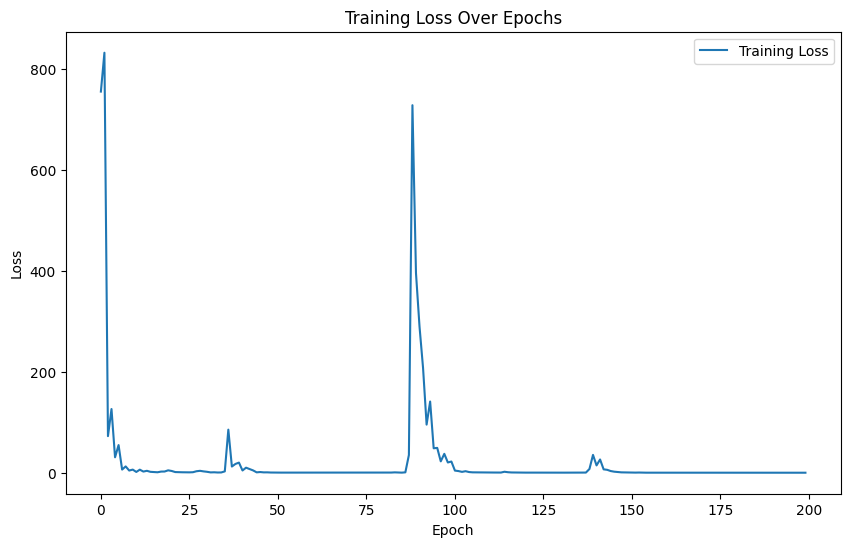

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader, Batch
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import pandas as pd

class SiameseGCNModel(nn.Module):
    def __init__(self, node_in_dims, node_out_dims=64):
        super(SiameseGCNModel, self).__init__()
        self.gcn1 = GCNConv(node_in_dims, node_out_dims)
        self.gcn2 = GCNConv(node_out_dims, node_out_dims)
        self.fc1 = nn.Linear(node_out_dims * 2, node_out_dims)  # Process concatenated features
        self.fc2 = nn.Linear(node_out_dims, 1)  # Final scalar output

    def forward(self, apo_data, holo_data):
        apo_x = self.process_structure(apo_data)
        holo_x = self.process_structure(holo_data)
        combined = torch.cat([apo_x, holo_x], dim=1)
        combined = F.relu(self.fc1(combined))
        combined = self.fc2(combined).squeeze()  # Ensure output is a single scalar per graph pair
        return combined

    def process_structure(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.gcn1(x, edge_index))
        x = self.gcn2(x, edge_index)
        x = global_mean_pool(x, data.batch)  # Apply global mean pooling
        return x

def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for apo_batch, holo_batch in loader:
        apo_batch, holo_batch = apo_batch.to(device), holo_batch.to(device)

        # Ensure the target labels are aggregated to graph-level correctly
        target_labels = []
        for i in range(apo_batch.num_graphs):
            mask = apo_batch.batch == i
            target_labels.append(apo_batch.y[mask].float().mean())
        target_labels = torch.tensor(target_labels, device=device)

        optimizer.zero_grad()
        output = model(apo_batch, holo_batch)
        loss = criterion(output, target_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)
def load_data_pairs(apo_folder='sg', holo_folder='sh', pairs_file='apo/candidate_pairs.txt'):
    pairs = pd.read_csv(pairs_file, delim_whitespace=True)
    data_pairs = []

    for index, row in pairs.iterrows():
        apo_prefix = f"{row['apo_pdb_id']}_{row['apo_chain_id']}"
        holo_prefix = f"{row['holo_pdb_id']}_{row['holo_chain_id']}"

        apo_graph_path = os.path.join(apo_folder, f'{apo_prefix}_graph.pt')
        holo_graph_path = os.path.join(holo_folder, f'{holo_prefix}_graph.pt')

        if os.path.exists(apo_graph_path) and os.path.exists(holo_graph_path):
            apo_graph = torch.load(apo_graph_path)
            holo_graph = torch.load(holo_graph_path)
            data_pairs.append((apo_graph, holo_graph))

    return data_pairs

def collate_graphs(data_list):
    apo_data_list, holo_data_list = zip(*data_list)
    apo_batch = Batch.from_data_list(apo_data_list)
    holo_batch = Batch.from_data_list(holo_data_list)
    return apo_batch, holo_batch




data_pairs = load_data_pairs()
train_loader = DataLoader(data_pairs, batch_size=32, shuffle=True, collate_fn=collate_graphs)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseGCNModel(node_in_dims=20).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


num_epochs = 200
loss_history = []

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    loss = train(model, train_loader, optimizer, criterion, device)
    loss_history.append(loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}')

# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

/home/flahaari/.local/lib/python3.8/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Epochs:   7%|██▍                                 | 1/15 [00:04<01:07,  4.85s/it]

Epoch 1/15, Train Loss: 106.2468, Test Loss: 42.7411, Train Pearson: 0.0501, Test Pearson: -0.1890


Epochs:  13%|████▊                               | 2/15 [00:09<01:03,  4.91s/it]

Epoch 2/15, Train Loss: 514.0892, Test Loss: 22.8541, Train Pearson: 0.0501, Test Pearson: 0.2135


Epochs:  20%|███████▏                            | 3/15 [00:14<00:58,  4.89s/it]

Epoch 3/15, Train Loss: 196.9876, Test Loss: 52.0856, Train Pearson: 0.0501, Test Pearson: 0.3349


Epochs:  27%|█████████▌                          | 4/15 [00:19<00:53,  4.91s/it]

Epoch 4/15, Train Loss: 155.8546, Test Loss: 19.0227, Train Pearson: 0.0501, Test Pearson: -0.1353


Epochs:  33%|████████████                        | 5/15 [00:24<00:49,  5.00s/it]

Epoch 5/15, Train Loss: 17.5768, Test Loss: 72.3066, Train Pearson: 0.0501, Test Pearson: -0.2600


Epochs:  40%|██████████████▍                     | 6/15 [00:30<00:47,  5.27s/it]

Epoch 6/15, Train Loss: 56.4821, Test Loss: 16.2931, Train Pearson: 0.0501, Test Pearson: -0.3433


Epochs:  47%|████████████████▊                   | 7/15 [00:35<00:42,  5.32s/it]

Epoch 7/15, Train Loss: 13.9956, Test Loss: 17.8739, Train Pearson: 0.0501, Test Pearson: 0.0213


Epochs:  53%|███████████████████▏                | 8/15 [00:41<00:36,  5.28s/it]

Epoch 8/15, Train Loss: 36.7759, Test Loss: 17.4361, Train Pearson: 0.0501, Test Pearson: 0.0155


Epochs:  60%|█████████████████████▌              | 9/15 [00:46<00:31,  5.30s/it]

Epoch 9/15, Train Loss: 13.8642, Test Loss: 4.4825, Train Pearson: 0.0501, Test Pearson: -0.3463


Epochs:  67%|███████████████████████▎           | 10/15 [00:51<00:26,  5.24s/it]

Epoch 10/15, Train Loss: 5.2595, Test Loss: 17.8460, Train Pearson: 0.0501, Test Pearson: -0.3135


Epochs:  73%|█████████████████████████▋         | 11/15 [00:56<00:20,  5.14s/it]

Epoch 11/15, Train Loss: 18.8706, Test Loss: 7.6952, Train Pearson: 0.0501, Test Pearson: -0.3035


Epochs:  80%|████████████████████████████       | 12/15 [01:01<00:15,  5.11s/it]

Epoch 12/15, Train Loss: 2.6802, Test Loss: 3.7250, Train Pearson: 0.0501, Test Pearson: -0.0481


Epochs:  87%|██████████████████████████████▎    | 13/15 [01:06<00:10,  5.05s/it]

Epoch 13/15, Train Loss: 10.0687, Test Loss: 3.3227, Train Pearson: 0.0501, Test Pearson: -0.0420


Epochs:  93%|████████████████████████████████▋  | 14/15 [01:11<00:05,  5.06s/it]

Epoch 14/15, Train Loss: 2.7601, Test Loss: 2.7167, Train Pearson: 0.0501, Test Pearson: -0.2188


Epochs: 100%|███████████████████████████████████| 15/15 [01:16<00:00,  5.11s/it]

Epoch 15/15, Train Loss: 3.1201, Test Loss: 5.3745, Train Pearson: 0.0501, Test Pearson: -0.2397


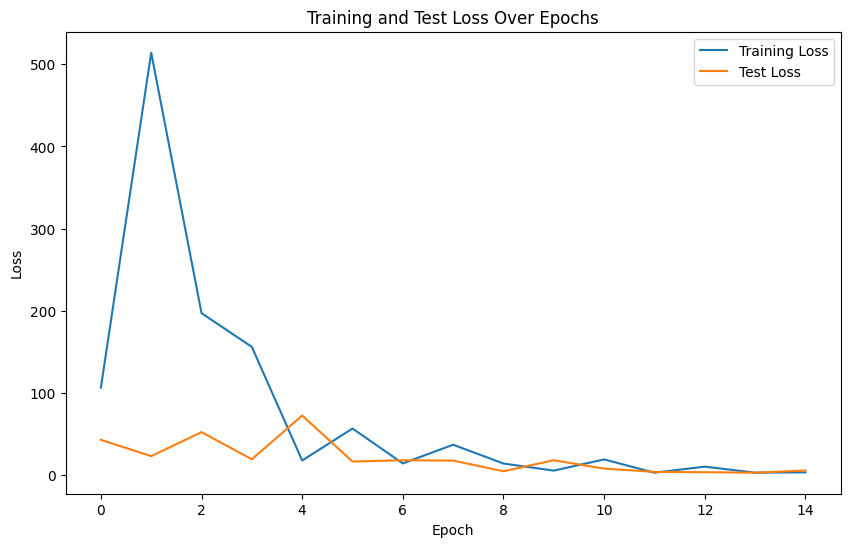

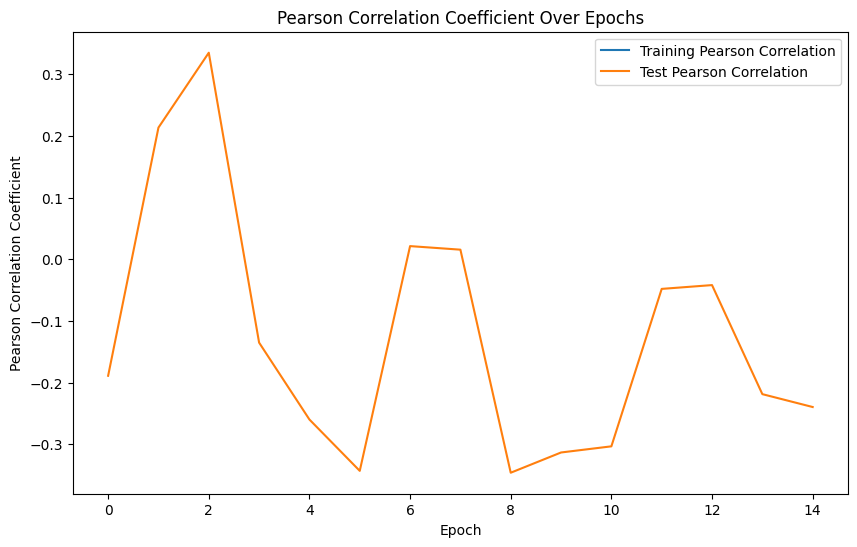

/tmp/ipykernel_163212/2782904644.py:149: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=train_ground_truth, y=train_predictions, cmap="Reds", shade=True, bw_adjust=0.5)


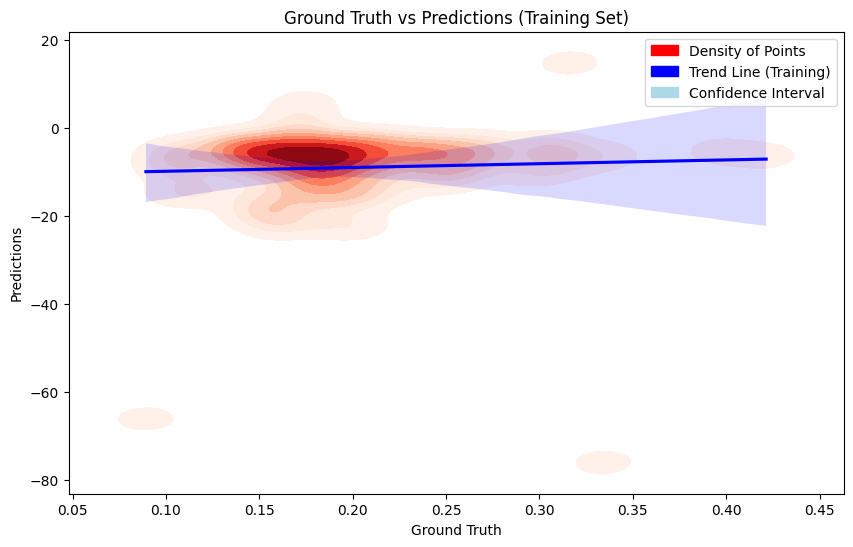

/tmp/ipykernel_163212/2782904644.py:162: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=test_ground_truth, y=test_predictions, cmap="Blues", shade=True, bw_adjust=0.5)


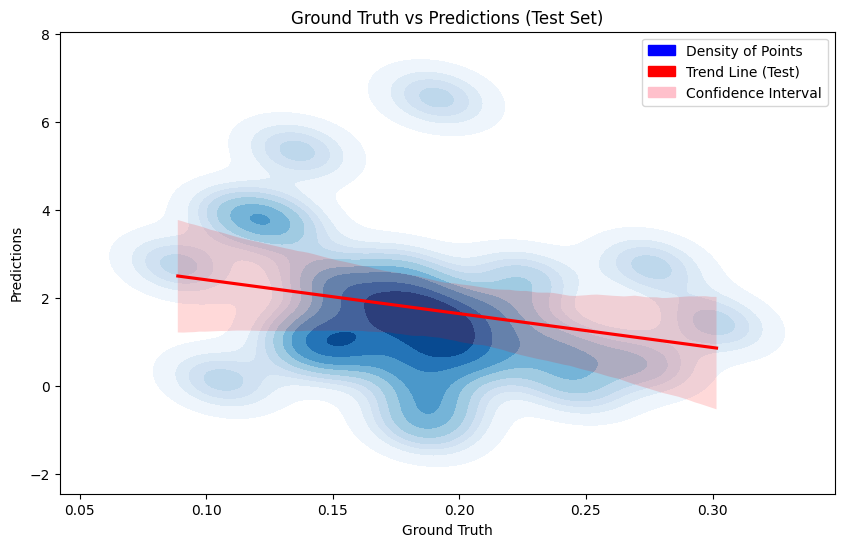

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader, Batch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import os
import pandas as pd
import matplotlib.patches as mpatches

class SiameseGCNModel(nn.Module):
    def __init__(self, node_in_dims, node_out_dims=64):
        super(SiameseGCNModel, self).__init__()
        self.gcn1 = GCNConv(node_in_dims, node_out_dims)
        self.gcn2 = GCNConv(node_out_dims, node_out_dims)
        self.fc1 = nn.Linear(node_out_dims * 2, node_out_dims)
        self.fc2 = nn.Linear(node_out_dims, 1)

    def forward(self, apo_data, holo_data):
        apo_x = self.process_structure(apo_data)
        holo_x = self.process_structure(holo_data)
        combined = torch.cat([apo_x, holo_x], dim=1)
        combined = F.relu(self.fc1(combined))
        combined = self.fc2(combined).squeeze()
        return combined

    def process_structure(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.gcn1(x, edge_index))
        x = self.gcn2(x, edge_index)
        x = global_mean_pool(x, data.batch)
        return x

def load_data_pairs(apo_folder='sg', holo_folder='sh', pairs_file='apo/candidate_pairs.txt'):
    pairs = pd.read_csv(pairs_file, delim_whitespace=True)
    data_pairs = []
    for index, row in pairs.iterrows():
        apo_prefix = f"{row['apo_pdb_id']}_{row['apo_chain_id']}"
        holo_prefix = f"{row['holo_pdb_id']}_{row['holo_chain_id']}"
        apo_graph_path = os.path.join(apo_folder, f'{apo_prefix}_graph.pt')
        holo_graph_path = os.path.join(holo_folder, f'{holo_prefix}_graph.pt')
        if os.path.exists(apo_graph_path) and os.path.exists(holo_graph_path):
            apo_graph = torch.load(apo_graph_path)
            holo_graph = torch.load(holo_graph_path)
            data_pairs.append((apo_graph, holo_graph))
    return data_pairs

def collate_graphs(data_list):
    apo_data_list, holo_data_list = zip(*data_list)
    apo_batch = Batch.from_data_list(apo_data_list)
    holo_batch = Batch.from_data_list(holo_data_list)
    return apo_batch, holo_batch

def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for apo_batch, holo_batch in loader:
        apo_batch, holo_batch = apo_batch.to(device), holo_batch.to(device)
        target_labels = torch.tensor([apo_batch.y[apo_batch.batch == i].float().mean() for i in range(apo_batch.num_graphs)], device=device)
        optimizer.zero_grad()
        output = model(apo_batch, holo_batch)
        loss = criterion(output, target_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

data_pairs = load_data_pairs()
train_pairs, test_pairs = train_test_split(data_pairs, test_size=0.2, random_state=42)

train_loader = DataLoader(train_pairs, batch_size=32, shuffle=True, collate_fn=collate_graphs)
test_loader = DataLoader(test_pairs, batch_size=32, shuffle=False, collate_fn=collate_graphs)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseGCNModel(node_in_dims=20).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

num_epochs = 15
train_loss_history = []
test_loss_history = []
train_pearson_history = []
test_pearson_history = []

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    train_loss_history.append(train_loss)

    model.eval()
    total_test_loss = 0
    test_predictions, test_ground_truth = [], []
    with torch.no_grad():
        for apo_batch, holo_batch in test_loader:
            apo_batch, holo_batch = apo_batch.to(device), holo_batch.to(device)
            output = model(apo_batch, holo_batch).squeeze()  

            labels = []
            for i in range(apo_batch.num_graphs):
                mask = apo_batch.batch == i
                labels.append(apo_batch.y[mask].float().mean())
            labels = torch.tensor(labels, device=device)


            if output.shape != labels.shape:
                print(f"Shape mismatch: output shape {output.shape}, labels shape {labels.shape}")
                continue

            loss = criterion(output, labels)
            total_test_loss += loss.item()

            test_predictions.extend(output.cpu().numpy())
            test_ground_truth.extend(labels.cpu().numpy())

    avg_test_loss = total_test_loss / len(test_loader)
    test_loss_history.append(avg_test_loss)
    test_pearson_corr = pearsonr(test_predictions, test_ground_truth)[0]
    test_pearson_history.append(test_pearson_corr)


    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Train Pearson: {train_pearson_corr:.4f}, Test Pearson: {test_pearson_corr:.4f}')


plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(train_pearson_history, label='Training Pearson Correlation')
plt.plot(test_pearson_history, label='Test Pearson Correlation')
plt.xlabel('Epoch')
plt.ylabel('Pearson Correlation Coefficient')
plt.title('Pearson Correlation Coefficient Over Epochs')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
sns.kdeplot(x=train_ground_truth, y=train_predictions, cmap="Reds", shade=True, bw_adjust=0.5)
sns.regplot(x=train_ground_truth, y=train_predictions, scatter=False, color='blue')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('Ground Truth vs Predictions (Training Set)')
density_patch = mpatches.Patch(color='red', label='Density of Points')
trend_line_patch = mpatches.Patch(color='blue', label='Trend Line (Training)')
confidence_interval_patch = mpatches.Patch(color='lightblue', label='Confidence Interval')
plt.legend(handles=[density_patch, trend_line_patch, confidence_interval_patch])
plt.show()


plt.figure(figsize=(10, 6))
sns.kdeplot(x=test_ground_truth, y=test_predictions, cmap="Blues", shade=True, bw_adjust=0.5)
sns.regplot(x=test_ground_truth, y=test_predictions, scatter=False, color='red')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('Ground Truth vs Predictions (Test Set)')
density_patch = mpatches.Patch(color='blue', label='Density of Points')
trend_line_patch = mpatches.Patch(color='red', label='Trend Line (Test)')
confidence_interval_patch = mpatches.Patch(color='pink', label='Confidence Interval')
plt.legend(handles=[density_patch, trend_line_patch, confidence_interval_patch])
plt.show()